# Assignment 4: Correlation Analysis and Bootstrapping

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and bootstrapping, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 
5. How to estimate a population parameter based on a sample?
6. How to use the bootstrap to quantify the uncertainty of an estimated value?

**Requirements:**
* Use [pandas](https://pandas.pydata.org/) to manipulate data.
* Use [matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org) to make plots.
* Please pay attention to visualization principles. 


The data can be downloaded from [A4-data.zip](A4-data.zip).


## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct a correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a property_tax_report from this [webpage](https://data.vancouver.ca/datacatalogue/propertyTax.htm). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2019.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [232]:
import pandas as pd

df = pd.read_csv("property_tax_report_2019.csv")


df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE'] \
                                        +x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose postcode starts with 'V6A'. Furthermore, we remove the houses that were built before 1900.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

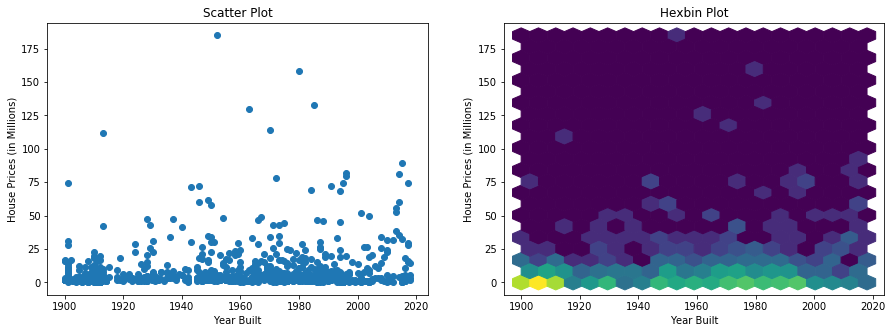

In [233]:
#<-- Write Your Code -->
#processing data, removing houses not havin "V6A" and built before 1900
import matplotlib.pyplot as plt

df = df[df['PROPERTY_POSTAL_CODE'].str.startswith("V6A",na=False) & (df['YEAR_BUILT'] >= 1900) & (df['LEGAL_TYPE'] == 'LAND')]

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(15, 5))

ax=axs[0]
ax.set_title("Scatter Plot")
ax.set_ylabel("House Prices (in Millions)")
ax.set_xlabel("Year Built")
ax.scatter(x=df['YEAR_BUILT'], y=df['HOUSE_PRICE']);

ax=axs[1]
ax.set_title("Hexbin Plot")
ax.set_xlabel("Year Built")
ax.set_ylabel("House Prices (in Millions)")
ax.hexbin(x=df['YEAR_BUILT'], y=df['HOUSE_PRICE'], gridsize=20, bins="log");



Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. In 1940-1960, there were properties built whose values were much higher as compared to the others. An important analysis following this could be- taking the size (or type) of the houses built, which could serve an actual comparison of the trends of more 'related' house prices.  
2. House prices are densely populated between 0-25M for most of the years, for the period between 1990-2020, there has been some upsurge in higher valued houses (>25M) built.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insights. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


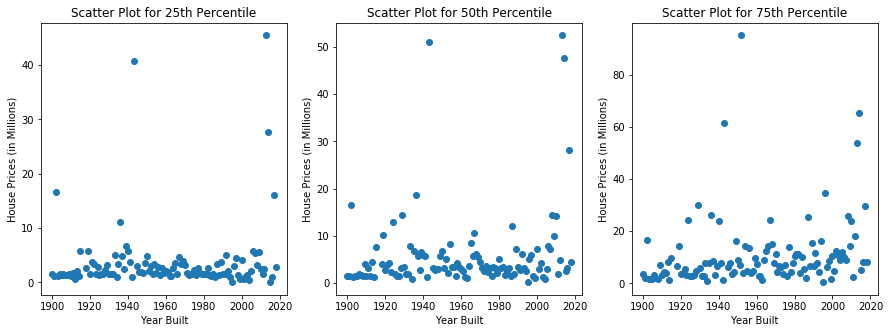

In [234]:
#<-- Write Your Code -->
df_grouped_year = df.groupby('YEAR_BUILT')

df_quantiles = df_grouped_year['HOUSE_PRICE'].quantile([0.25, 0.5, 0.75]).unstack()
df_quantiles =df_quantiles.reset_index()
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 5))

ax=axs[0]
ax.set_title("Scatter Plot for 25th Percentile")
ax.set_ylabel("House Prices (in Millions)")
ax.set_xlabel("Year Built")
ax.scatter(x=df_quantiles['YEAR_BUILT'], y=df_quantiles[0.25]);


ax=axs[1]
ax.set_title("Scatter Plot for 50th Percentile")
ax.set_ylabel("House Prices (in Millions)")
ax.set_xlabel("Year Built")
ax.scatter(x=df_quantiles['YEAR_BUILT'], y=df_quantiles[0.50]);


ax=axs[2]
ax.set_title("Scatter Plot for 75th Percentile")
ax.set_ylabel("House Prices (in Millions)")
ax.set_xlabel("Year Built")
ax.scatter(x=df_quantiles['YEAR_BUILT'], y=df_quantiles[0.75]);



Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The House prices in the 25th percentile, are clustered around (0-10M), values in 50th percentile, show a more dispersed plot.
2. The values of house prices in the 75th percentile, show a slightly increasing trend as the years passed. This could maybe interpreted as the luxury housing market (the top 75% of the houses) pricing in Vancouver, has gone up as the years have passed.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please implement `calc_pearson()` and `calc_spearman()`, respectively. Note that you are *NOT* allowed to use [corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) from Pandas or [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr)/[spearmanr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr) from scipy.stats to do this task. In other words, you need to implement the actual algorithms for pearson and spearman.

In [235]:
import math
def calc_pearson(df, x, y):
    #<-- Write Your Code -->   
    xmean= df[x].mean()
    ymean= df[y].mean()
    df['xi-xmean'] = df[x]-xmean
    df['yi-ymean'] = df[y]-ymean
    df['xdiff*ydiff'] = df['xi-xmean']*df['yi-ymean']
    cov = df['xdiff*ydiff'].sum()/(len(df))
    
    df['yi-ymean*2'] = df['yi-ymean']**2
    df['xi-xmean*2'] = df['xi-xmean']**2
    sd_x = math.sqrt((df['xi-xmean*2'].sum())/(len(df)))
    sd_y = math.sqrt((df['yi-ymean*2'].sum())/(len(df)))
    
    pearson_corr = cov/(sd_x*sd_y)
    
    return pearson_corr
    

def calc_spearman(df, x, y):
    #<-- Write Your Code -->
    df['x_rank'] = df[x].rank(method="max")
    df['y_rank'] = df[y].rank(method="max")
    #using the function calc_pearson again
    return calc_pearson(df,'x_rank','y_rank')
        


Then, you can use these two functions to compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>. 

In [236]:
dfcor = df_quantiles[['YEAR_BUILT',0.25,0.50,0.75]]
dfcor = dfcor.rename(columns= {0.25:"25TH_HOUSE_PRICE",0.50:"50TH_HOUSE_PRICE",0.75:"75TH_HOUSE_PRICE"})

print(dfcor.head(10))


for TH in ["25TH", "50TH", "75TH"]:
    print(TH+"_HOUSE_PRICE\t pearson=%f\t spearman=%f"  \
          %(calc_pearson(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE"), \
            calc_spearman(dfcor, "YEAR_BUILT", TH+"_HOUSE_PRICE")))

   YEAR_BUILT  25TH_HOUSE_PRICE  50TH_HOUSE_PRICE  75TH_HOUSE_PRICE
0      1900.0          1.550200           1.62600            3.5750
1      1901.0          1.189925           1.50700            2.0005
2      1902.0         16.614000          16.61400           16.6140
3      1903.0          1.246150           1.42620            1.5063
4      1904.0          1.454500           1.57920            1.6143
5      1905.0          1.378200           1.49100            1.6730
6      1906.0          1.452350           2.01700            3.1472
7      1907.0          1.448550           1.71800            2.0550
8      1908.0          1.321000           1.47480            1.6970
9      1909.0          1.500225           4.04085            6.8510
25TH_HOUSE_PRICE	 pearson=0.112608	 spearman=0.033614
50TH_HOUSE_PRICE	 pearson=0.185711	 spearman=0.186584
75TH_HOUSE_PRICE	 pearson=0.225439	 spearman=0.389536


<img src="correlation-result.png",align="left",width=500,height=500>

Please write down the **two** most interesting findings that you draw from the result.

**Findings**
1. The 25th percentile values show the least positive correlation value as the years passed, indicating that average prices of 'basic' houses in Vancouver (could include majority of houses in downtown eastside), haven't increased much.
2. The 75th percentile values show the most positive correlation value (considering Spearman correlation), which points to the case of luxury housing market prices in Vancouver (possibly in Gastown) increasing as the years went by.

## Part 2. Bootstrapping

In reality, it is more often than not that you can only collect a sample of the data. Whenever you derive a conclusion from a sample (e.g., Vancouver's housing price has increased by 10% since last year), you should ALWAYS ask yourself: **"CAN I TRUST IT?"**. In other words, you want to know that if the same analysis was conducted on the full data, would the same conclusion be derived? In Part 2, you will learn how to use bootstrapping to answer this question. 

In [240]:
df_sample = pd.read_csv("property_tax_report_2019_sample.csv")

df_sample['CURRENT_PRICE'] = df_sample.apply(lambda x: x['CURRENT_LAND_VALUE'] \
                                             +x['CURRENT_IMPROVEMENT_VALUE'], axis = 1)

df_sample['PREVIOUS_PRICE'] = df_sample.apply(lambda x: x['PREVIOUS_LAND_VALUE'] \
                                              +x['PREVIOUS_IMPROVEMENT_VALUE'], axis = 1)

df_sample = df_sample[df_sample['LEGAL_TYPE'] == 'STRATA']

### Task 1. Analysis Result Without Bootstrapping

Please compute the median of PREVIOUS_PRICE and CURRENT_PRICE, respectively, and compare them in a bar chart.

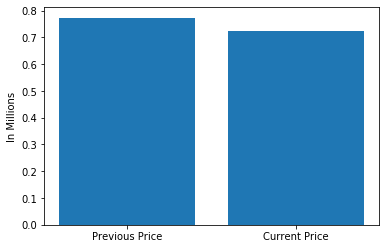

In [244]:
# --- Write your code below ---
import numpy as np

toMillions= 1000000
y_axisList = [df_sample['PREVIOUS_PRICE'].median()/toMillions,df_sample['CURRENT_PRICE'].median()/toMillions]

x = np.arange(2)
fig, ax = plt.subplots()
plt.bar(x,y_axisList)
plt.ylabel("In Millions")
plt.xticks(x, ('Previous Price', 'Current Price'))
plt.show()


### Task 2. Analysis Result With Bootstrapping

From the above chart, we find that the median of PREVIOUS_PRICE is about 0.77 M, and the median of CURRENT_PRICE is about 0.72 M. Since the numbers were obtained from the sample, **"CAN WE TRUST THESE NUMBERS?"**

In the following, please implement the bootstrap by yourself, compute a 95%-confidence interval for each number, and add the confidence intervals to the above bar chart. [This document](./MIT18_05S14_Reading24.pdf) gives a good tutorial about the bootstrap. You can find the description of the algorithm in Section 7.

Confidence interval for previous price  [741500.0, 810000.0]
Confidence interval for current price  [690200.0, 751500.0]


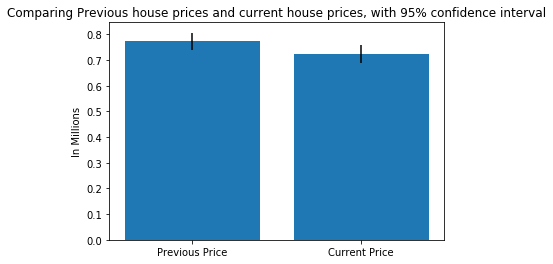

In [259]:
# --- Write your code below ---
import math 

#calc median of sample distribution
sample_prev_price_median = df_sample['PREVIOUS_PRICE'].median()
sample_curr_price_median = df_sample['CURRENT_PRICE'].median()
iters = 1000
delta_star_prev_price = np.zeros(iters)
delta_star_curr_price = np.zeros(iters)

prev_price_np = df_sample['PREVIOUS_PRICE'].to_numpy()
curr_price_np = df_sample['CURRENT_PRICE'].to_numpy()

for i in range(iters):
    
    sample_prev = np.random.choice(prev_price_np,573,replace=True)
    
    sample_curr = np.random.choice(curr_price_np,573,replace=True)
    #median of bootstrap sample
    bootstrapped_median_prev = pd.DataFrame(sample_prev,columns=['bootstrapped_prev_price']).median()
    delta_star_prev_price[i] = bootstrapped_median_prev - sample_prev_price_median
    bootstrapped_curr_price = pd.DataFrame(sample_curr,columns=['bootstrapped_curr_price']).median()
    #compute differences between bootstrap median and sample median
    delta_star_curr_price[i] = bootstrapped_curr_price - sample_curr_price_median


#sort in ascending order, to select the right percentile value
sorted_delta_star_prev_price = np.sort(delta_star_prev_price)
sorted_delta_star_curr_price = np.sort(delta_star_curr_price)
#taking the 25th price for critical value of del_0.025, and 975th price for the critical value of del_0.975
value_25th = sorted_delta_star_prev_price[24]
value_975th = sorted_delta_star_prev_price[974]
print("Confidence interval for previous price ", [sample_prev_price_median-value_975th,sample_prev_price_median-value_25th])
value_25th = sorted_delta_star_curr_price[24]
value_975th = sorted_delta_star_curr_price[974]
print("Confidence interval for current price ", [sample_curr_price_median-value_975th,sample_curr_price_median-value_25th])

#plotting bars with error
err = np.array([[math.fabs(sorted_delta_star_curr_price[974])/toMillions , math.fabs(sorted_delta_star_prev_price[24])/toMillions],
                [math.fabs(sorted_delta_star_curr_price[974])/toMillions , math.fabs(sorted_delta_star_prev_price[24])/toMillions]])


y_axisList = [df_sample['PREVIOUS_PRICE'].median()/toMillions,df_sample['CURRENT_PRICE'].median()/toMillions]

x = np.arange(2)
fig, ax = plt.subplots()
ax.set_title("Comparing Previous house prices and current house prices, with 95% confidence interval")
plt.bar(x,y_axisList, yerr =err, align="center")
plt.ylabel("In Millions")
plt.xticks(x, ('Previous Price', 'Current Price'))
plt.show()

## Submission

Complete the code in this notebook, and submit it to the CourSys activity Assignment 4.